 # Novelty detection + posteriors

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.random import normal, shuffle, uniform
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor


def get_ece(predicted_posterior, predicted_label, true_label, num_bins=40):
    bin_size = 1 / num_bins
    total_sample = len(true_label)
    posteriors = predicted_posterior.max(axis=1)

    score = 0
    for bin in range(num_bins):
        indx = np.where(
            (posteriors > bin * bin_size) & (posteriors <= (bin + 1) * bin_size)
        )[0]

        acc = (
            np.nan_to_num(np.mean(predicted_label[indx] == true_label[indx]))
            if indx.size != 0
            else 0
        )
        conf = np.nan_to_num(np.mean(posteriors[indx])) if indx.size != 0 else 0
        score += len(indx) * np.abs(acc - conf)

    score /= total_sample
    return score


def hellinger(p, q):
    """Hellinger distance between two discrete distributions.
    Same as original version but without list comprehension
    """
    return np.mean(np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2, axis=1)) / np.sqrt(2))


def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R


def _clean_Xy(X, y):
    """
    Remove first junk index from X and y and randomly shuffle the entries.
    Parameters
    ----------
    X : array of shape [n_samples+1, x]
        The generated samples.
    y : array of shape [n_samples+1]
        The integer labels for cluster membership of each sample.
    Returns
    -------
    X : array of shape [n_samples, x]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """
    index = np.arange(1, y.size)
    shuffle(index)
    return (X[index, :], y[index])


def _length(x):
    """
    length function with error catching for ints/floats.
    """
    try:
        return len(x)
    except TypeError:
        return 1


def generate_gaussian_parity(
    n_samples,
    centers=None,
    class_label=None,
    cluster_std=0.25,
    bounding_box=(-1.0, 1.0),
    angle_params=None,
    random_state=None,
):
    """
    Generate 2-dimensional Gaussian XOR distribution.
    (Classic XOR problem but each point is the
    center of a Gaussian blob distribution)
    Parameters
    ----------
    n_samples : int
        Total number of points divided among the four
        clusters with equal probability.
    centers : array of shape [n_centers,2], optional (default=None)
        The coordinates of the ceneter of total n_centers blobs.
    class_label : array of shape [n_centers], optional (default=None)
        class label for each blob.
    cluster_std : float, optional (default=1)
        The standard deviation of the blobs.
    bounding_box : tuple of float (min, max), default=(-1.0, 1.0)
        The bounding box within which the samples are drawn.
    angle_params: float, optional (default=None)
        Number of radians to rotate the distribution by.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X = np.zeros((1, 2), dtype=float)
    y = np.zeros((1), dtype=float)
    ii = 0
    for center, sample in zip(centers, samples_per_blob):
        X_, _ = make_blobs(
            n_samples=sample * 10,
            n_features=2,
            centers=[center],
            cluster_std=cluster_std,
        )
        col1 = (X_[:, 0] > bounding_box[0]) & (X_[:, 0] < bounding_box[1])
        col2 = (X_[:, 1] > bounding_box[0]) & (X_[:, 1] < bounding_box[1])
        X_ = X_[col1 & col2]
        X = np.concatenate((X, X_[:sample, :]), axis=0)
        y_ = np.array([class_label[ii]] * sample)
        y = np.concatenate((y, y_), axis=0)
        ii += 1

    X, y = X[1:], y[1:]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y.astype(int)


def pdf(x, cov_scale=0.25):
    mu01 = np.array([-0.5, 0.5])
    mu02 = np.array([0.5, -0.5])
    mu11 = np.array([0.5, 0.5])
    mu12 = np.array([-0.5, -0.5])
    cov = cov_scale * np.eye(2)
    inv_cov = np.linalg.inv(cov)

    p01 = (np.exp(-0.5 * (x - mu01) @ inv_cov @ (x - mu01).T)) / (
        2 * np.pi * np.sqrt(np.linalg.det(cov))
    )
    p02 = (np.exp(-0.5 * (x - mu02) @ inv_cov @ (x - mu02).T)) / (
        2 * np.pi * np.sqrt(np.linalg.det(cov))
    )
    p11 = (
        np.exp(-0.5 * (x - mu11) @ inv_cov @ (x - mu11).T)
        + np.exp(-0.5 * (x - mu12) @ inv_cov @ (x - mu12).T)
    ) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
    p12 = (np.exp(-0.5 * (x - mu12) @ inv_cov @ (x - mu12).T)) / (
        2 * np.pi * np.sqrt(np.linalg.det(cov))
    )

    return np.max([p01, p02]) / (p01 + p02 + p11 + p12)


def sparse_parity(n_samples, p_star=3, p=20):
    X = np.random.uniform(low=-1, high=1, size=(n_samples, p))
    y = np.sum(X[:, :p_star] > 0, axis=1) % 2

    return X, y.astype(int)


def gaussian_sparse_parity(
    n_samples,
    centers=None,
    class_label=None,
    p_star=3,
    p=20,
    cluster_std=0.25,
    center_box=(-1.0, 1.0),
    random_state=None,
):
    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        if p_star == 2:
            centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])
        else:
            centers = np.array(
                [
                    (0.5, 0.5, 0.5),
                    (-0.5, 0.5, 0.5),
                    (0.5, -0.5, 0.5),
                    (0.5, 0.5, -0.5),
                    (0.5, -0.5, -0.5),
                    (-0.5, -0.5, 0.5),
                    (-0.5, 0.5, -0.5),
                    (-0.5, -0.5, -0.5),
                ]
            )

    if class_label == None:
        class_label = 1 - np.sum(centers[:, :p_star] > 0, axis=1) % 2

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=p_star,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if p > p_star:
        X_noise = np.random.uniform(
            low=center_box[0], high=center_box[1], size=(n_samples, p - p_star)
        )
        X = np.concatenate((X, X_noise), axis=1)

    return X, y.astype(int)


def trunk_sim(n_samples, p_star=3, p=3, center_box=(-1.0, 1.0), random_state=None):
    samples_per_class = np.random.multinomial(n_samples, 1 / 2 * np.ones(2))

    mean = 1.0 / np.sqrt(np.arange(1, p_star + 1, 1))

    X = np.concatenate(
        (
            np.random.multivariate_normal(
                mean, np.eye(p_star), size=samples_per_class[0]
            ),
            np.random.multivariate_normal(
                -mean, np.eye(p_star), size=samples_per_class[1]
            ),
        ),
        axis=0,
    )
    y = np.concatenate(
        (np.zeros(samples_per_class[0]), np.ones(samples_per_class[1])), axis=0
    )

    if p > p_star:
        X_noise = np.random.uniform(
            low=center_box[0], high=center_box[1], size=(n_samples, p - p_star)
        )
        X = np.concatenate((X, X_noise), axis=1)

    return X, y.astype(int)


def generate_spirals(
    n_samples, n_class=2, noise=0.3, bounding_box=(-1.0, 1.0), random_state=None,
):
    """
    Generate 2-dimensional spiral simulation
    Parameters
    ----------
    n_samples : int
        Total number of points divided among the individual spirals.
    n_class : array of shape [n_centers], optional (default=2)
        Number of class for the spiral simulation.
    noise : float, optional (default=0.3)
        Parameter controlling the spread of each class.
    bounding_box : tuple of float (min, max), default=(-1.0, 1.0)
        The bounding box within which the samples are drawn. (currently works
        for only 2 classes)
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """

    if random_state != None:
        np.random.seed(random_state)

    X = []
    y = []

    if n_class == 2:
        turns = 2
    elif n_class == 3:
        turns = 2.5
    elif n_class == 5:
        turns = 3.5
    elif n_class == 7:
        turns = 4.5
    else:
        raise ValueError("sorry, can't currently support %s classes " % n_class)

    mvt = np.random.multinomial(n_samples, 1 / n_class * np.ones(n_class))

    if n_class == 2:
        lim = max(np.abs(bounding_box[0]), np.abs(bounding_box[1]))
        r = np.random.uniform(0, lim, size=int(n_samples / n_class))
        r = np.sort(r)
        t = np.linspace(
            0, np.pi * 4 * turns / n_class, int(n_samples / n_class)
        ) + np.random.normal(0, noise, int(n_samples / n_class))
        dx = r * np.cos(t)
        dy = r * np.sin(t)

        X.append(np.vstack([dx, dy]).T)
        X.append(np.vstack([-dx, -dy]).T)
        y += [0] * int(n_samples / n_class)
        y += [1] * int(n_samples / n_class)
    else:
        for j in range(1, n_class + 1):
            r = np.linspace(0.01, 1, int(mvt[j - 1]))
            t = np.linspace(
                (j - 1) * np.pi * 4 * turns / n_class,
                j * np.pi * 4 * turns / n_class,
                int(mvt[j - 1]),
            ) + np.random.normal(0, noise, int(mvt[j - 1]))

            dx = r * np.cos(t)
            dy = r * np.sin(t)

            dd = np.vstack([dx, dy]).T
            X.append(dd)
            y += [j - 1] * int(mvt[j - 1])

    return np.vstack(X), np.array(y).astype(int)


def generate_ellipse(
    n_samples,
    width=(1, 0.75),
    height=None,
    offsets=None,
    sigma=0.1,
    bounding_box=(-1.0, 1.0),
    random_state=None,
):
    """
    Generate axis-aligned ellipse simulation.
    (Categorization between ellipses)
    Parameters
    ----------
    n_samples : int
        Total number of points in simulation, evenly divided between ellipses.
    width : ndarray-like of shape [n_ellipses, 2], optional (default=(1, 0.75))
        Width of ellipses, measured from the origin to right bound.
        width and height must be able to be broadcasted to the same size.
    height : ndarray-like of shape [n_ellipses, 2], optional (default=None)
        Height of ellipses, measured from the origin to upper bound.
        width and height must be able to be broadcasted to the same size.
        If None, height=width(concentric circles simulation)
    offsets : ndarray-like of shape [n_ellipses, 2], optional (default=None)
        Centers of the ellipses.
        If None, all ellipses are centered at (0, 0)
    sigma : float, optional (default=0.1)
        Parameter controlling the width of the shapes.
    bounding_box : tuple of float (min, max), default=(-1.0, 1.0)
        The bounding box within which the samples are drawn.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """
    if random_state is None:
        np.random.seed(random_state)

    width = np.asarray(width)
    if height is None:
        height = width
    elif type(height) == int or type(height) == float:
        height = np.ones_like(width) * height
    else:
        height = np.asarray(height)
    if offsets is not None:
        offsets = np.asarray(offsets)

    n_ellipses = width.size

    X = np.empty((1, 2))
    y = np.array(1)
    for n in range(n_ellipses):
        size = n_samples / n_ellipses
        if type(size) == float:
            size = int(size)
            if n == n_ellipses:
                size = size + 1

        t = uniform(0, 2 * np.pi, 10 * size)
        a = width[n] + normal(0, sigma, 10 * size)
        b = height[n] + normal(0, sigma, 10 * size)

        xn = np.column_stack((a * np.cos(t), b * np.sin(t)))

        if offsets is not None:
            xn = xn + offsets[n, :]

        col1 = (xn[:, 0] > bounding_box[0]) & (xn[:, 0] < bounding_box[1])
        col2 = (xn[:, 1] > bounding_box[0]) & (xn[:, 1] < bounding_box[1])
        xn = xn[col1 & col2]
        xn = xn[:size]

        X = np.append(X, xn, axis=0)
        y = np.append(y, np.ones(size, dtype=int) * n)

    X, y = _clean_Xy(X, y)
    return (X, y)


def generate_sinewave(
    n_samples,
    offsets=(0, 0.5),
    height=None,
    n_peaks=2,
    sigma=0.1,
    bounding_box=(-1.0, 1.0),
    random_state=None,
):
    """
    Generate sinewave simulation.
    (Categorization between offset/scaled sine waves)
    Parameters
    ----------
    n_samples : int
        Total number of points divided between sine waves.
    offsets : ndarray-like of shape [n_waves], optional (default: (0, 0.5))
        Horizontal offsets for the waves, as multiples of pi.
    height : ndarray-like of shape [n_waves], optional (default=None)
        Peak height of sine waves.
        If None, all waves will have a height of 1.
    n_peaks : int, optional (default=2)
        Number of peaks for each sine wave.
    sigma : float, optional (default=0.1)
        Parameter controlling the width of the shapes.
    bounding_box : tuple of float (min, max), default=(-1.0, 1.0)
        The bounding box within which the samples are drawn.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """
    if random_state != None:
        np.random.seed(random_state)

    n_waves = len(offsets)
    if height is None:
        mul = max(np.abs(bounding_box[0]), np.abs(bounding_box[1]))
        height = mul * np.ones(n_waves)

    X = np.empty((1, 2))
    y = np.array(1)
    for n in range(n_waves):
        size = n_samples / n_waves
        if type(size) == float:
            size = int(size)
            if n == n_waves:
                size = size + 1

        t_n = uniform(bounding_box[0], bounding_box[1], 10 * size)
        y_n = height[n] * np.sin(t_n * n_peaks * 2 + offsets[n] * np.pi) + normal(
            0, sigma, 10 * size
        )
        xn = np.column_stack((t_n, y_n))
        col1 = (xn[:, 0] > bounding_box[0]) & (xn[:, 0] < bounding_box[1])
        col2 = (xn[:, 1] > bounding_box[0]) & (xn[:, 1] < bounding_box[1])
        xn = xn[col1 & col2]
        xn = xn[:size]

        X = np.append(X, xn, axis=0)
        y = np.append(y, np.ones(size, dtype=int) * n)

    X, y = _clean_Xy(X, y)
    return (X, y)


def generate_steps(
    n_samples,
    step_start=(0, 0.25),
    n_steps=2,
    step_height=0.25,
    sigma=0.1,
    random_state=None,
):
    """
    Generate stepped simulation.
    (Categorization between noisy stepped distributions)
    Parameters
    ----------
    n_samples : int
        Total number of points in the simulation.
    step_start : ndarray-like (default=(0, 0.1))
        starting points for each series of steps.
    n_steps : int, optional (default=2)
        Number of steps per line to include in the simulation.
    step_height : float, optional (default=0.25)
        distance between steps
    sigma : float, optional (default=0.1)
        Parameter controlling the width of the shapes.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """
    if random_state != None:
        np.random.seed(random_state)

    if step_height is None:
        height = np.ones_like(step_start)
    elif type(step_height) == int or type(step_height) == float:
        height = np.ones_like(step_start) * step_height
    else:
        height = np.asarray(step_height)

    X = np.empty((1, 2))
    y = np.array(1)

    n_waves = len(step_start)

    for n in range(n_waves):
        size = n_samples / n_waves
        if type(size) == float:
            size = int(size)
            if n == n_waves:
                size = size + 1

        t_n = uniform(0, n_steps, size)
        y_n = step_start[n] + height[n] * np.floor(t_n) + normal(0, sigma, size)
        xn = np.column_stack((t_n, y_n))

        X = np.append(X, xn, axis=0)
        y = np.append(y, np.ones(size, dtype=int) * n)

    X, y = _clean_Xy(X, y)
    return (X, y)


def generate_polynomial(
    n_samples,
    m=1.0,
    a=1.0,
    b=0.0,
    sigma=0.1,
    bounding_box=(-1.0, 1.0),
    random_state=None,
):
    """
    Generate simulations of the form y = m(x^a)+b.
    (Categorization between equations)
    Parameters
    ----------
    n_samples : int
        Total number of points divided between ellipse boundary and noise
    m: float or ndarray-like (default=1.0)
        Coefficient of equations.
    a: float or ndarray-like (default=1.0)
        Exponent of equations.
    b: float or ndarray-like (default=0.0)
        Intercepts of equations.
    sigma : float, optional (default=0.1)
        Parameter controlling the width of the shapes.
    bounding_box : tuple of float (min, max), default=(-1.0, 1.0)
        The bounding box within which the samples are drawn.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """
    if random_state != None:
        np.random.seed(random_state)

    n_lines = max(_length(m), _length(a), _length(b))

    if type(m) == int or type(m) == float:
        m = np.ones(n_lines) * m
    else:
        m = np.asarray(m)

    if type(a) == int or type(a) == float:
        a = np.ones(n_lines) * a
    else:
        a = np.asarray(a)

    if type(b) == int or type(b) == float:
        b = np.ones(n_lines) * b
    else:
        b = np.asarray(b)

    X = np.empty((1, 2))
    y = np.array(1)

    for n in range(n_lines):
        size = n_samples / n_lines
        if type(size) == float:
            size = int(size)
            if n == n_lines:
                size = size + 1
        t_n = uniform(-1, 1, 10 * size)
        if a[n] < 1:
            y_n = m[n] * np.power(abs(t_n), a[n])
        else:
            y_n = m[n] * np.power(t_n, a[n])
        y_n = y_n + b[n] + normal(0, sigma, 10 * size)

        xn = np.column_stack((t_n, y_n))
        col1 = (xn[:, 0] > bounding_box[0]) & (xn[:, 0] < bounding_box[1])
        col2 = (xn[:, 1] > bounding_box[0]) & (xn[:, 1] < bounding_box[1])
        xn = xn[col1 & col2]
        xn = xn[:size]

        X = np.append(X, xn, axis=0)
        y = np.append(y, np.ones(size, dtype=int) * n)

    X, y = _clean_Xy(X, y)
    return (X, y)


def plot_2dsim(X, y, square_plot=False, ax=None):
    """
    Plot 2d simulations.
    Parameters
    ----------
    X : array of shape [n_samples, 2]
        The generated samples. Other dimensions will be ignored.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    square_plot : boolean (default: False)
        If plot should be forced to have square bounds, with (0, 0) at the center
    ax : matplotlib axes object (default: None)
        Axis to plot on. If None, a new axis object will be created.
    Returns
    -------
    ax : matplotlib axes object
        Plot of simulation data.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    samples = np.unique(y)

    if square_plot:
        floor = max(-np.rint(np.amin(X)), np.rint(np.amax(X)))
        print(floor)
        lim = [-floor, floor]
        ax.set_xlim(lim)
        ax.set_ylim(lim)

    colors = sns.color_palette("colorblind")
    for s in samples:
        ax.plot(X[y == s, 0], X[y == s, 1], marker=".", color=colors[s], linestyle="")

    return ax


def multiclass_guassian(n_samples, k=98):
    samples_per_blob = np.random.multinomial(n_samples, 1 / k * np.ones(k))
    sqrt_cls = np.ceil(np.sqrt(k))

    center_x = np.arange(0, sqrt_cls * 0.5, step=0.5)
    center_y = np.arange(0, sqrt_cls * 0.5, step=0.5)
    center_x, center_y = np.meshgrid(center_x, center_y)

    grid_samples = np.concatenate(
        (center_x.reshape(-1, 1), center_y.reshape(-1, 1)), axis=1
    )
    centers = grid_samples[:k]

    X, y = make_blobs(
        n_samples=samples_per_blob, n_features=2, centers=centers, cluster_std=0.25
    )

    return X, y


def generate_ood_samples(n, inbound=[1, -1], outbound=[5, -5]):
    Xood = []
    i = 0
    while True:
        x1 = (outbound[0] - outbound[1]) * np.random.random_sample() - outbound[0]
        x2 = (outbound[0] - outbound[1]) * np.random.random_sample() - outbound[0]
        if (-inbound[0] < x1 < inbound[1]) and (-inbound[0] < x2 < inbound[1]):
            continue
        else:
            Xood.append([x1, x2])
            i += 1
        if i >= n:
            break
    Xood = np.array(Xood)
    return Xood

In [2]:
# generate data
X, y = generate_ellipse(10000)

In [3]:
# fit a normal random forest
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X, y)

RandomForestClassifier(n_estimators=500)

In [4]:
# look at its posterior
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

posterior_rf = rf.predict_proba(grid_samples)
posterior_rf = posterior_rf[:, 0].reshape(400, 400)

In [5]:
# fit an outlier model
lof = LocalOutlierFactor(novelty=True)
lof.fit(X)
posterior_lof = lof.predict(grid_samples)
posterior_lof = 0.5 * (posterior_lof + 1)  # original are -1 (outlier) or 1 predictions
posterior_lof = posterior_lof.reshape(400, 400)

In [6]:
# combine
# give 1/2 if predicted outlier, RF posterior otherwise
joint_posterior = 0.5 * (1 - posterior_lof) + posterior_lof * posterior_rf

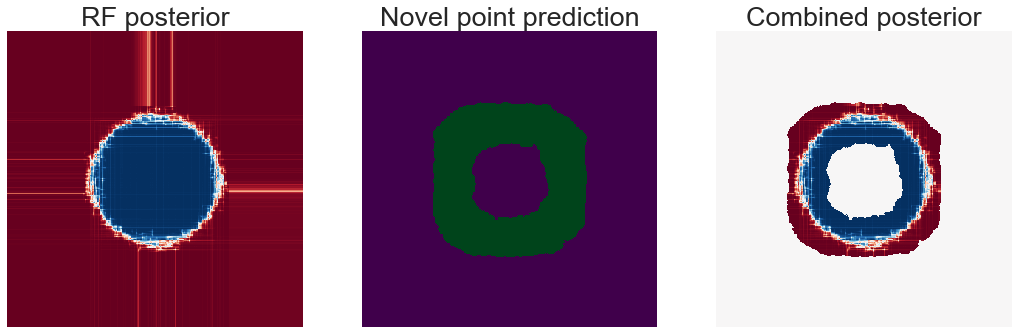

In [7]:
sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ax = axs[0]
sns.heatmap(
    posterior_rf,
    cmap="RdBu_r",
    center=0.5,
    vmax=1,
    vmin=0,
    ax=ax,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
)
ax.set_title("RF posterior")


ax = axs[1]
sns.heatmap(
    posterior_lof,
    cmap="PRGn",
    center=0.5,
    vmax=1,
    vmin=0,
    ax=ax,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
)
ax.set_title("Novel point prediction")

ax = axs[2]
sns.heatmap(
    joint_posterior,
    cmap="RdBu_r",
    center=0.5,
    vmax=1,
    vmin=0,
    ax=ax,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
)
ax.set_title("Combined posterior")

fig.set_facecolor("w")

plt.savefig(
    "one-offs/results/novelty_detection/novel_circle_sim.png",
    dpi=300,
    bbox_inches="tight",
)